## Group assignment - Annalaura Ianiro, Jordi Hurtado, Benjamin Wein

# SVM for hand-written digit recognition

As an example of support vector machines in action, let's take a look at the hand-written digit recognition problem. We will use the MNIST dataset, which consists of several thousand gray scale images of hand-written digits. You can load directly the dataset with sklearn.

The data consists of 8×8 pixel images, therefore they are 64-dimensional. 

In this exercise you should:

 - Visualize and present the dataset
 - Apply the SVC to perform multi-class classification
 - Comment on the usage of the different kernels and the effect of the hyper-parameters
 - Visualize the results with a confusion matrix
 - Create a grid with different test examples showing the predicted and the true label
 - Compute the accuracy score and comment on the results
 - Perform any other experiments that you can think of, always reason about the results!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from sklearn.datasets import load_digits
mnist = load_digits(n_class=10)

After downloading the dataset, print the general description of the dataset. Then print the target names and the shape of the images.

In [4]:
print(mnist.keys())

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])


In [5]:
print(mnist["DESCR"])

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each bloc

Now print again the shape of `mnist.images` and `mnist.data`. What do you think is the relationship between them?

In [6]:
mnist["images"].shape

(1797, 8, 8)

In [7]:
mnist["data"].shape

(1797, 64)

## EDA

The 64 features are a decomposition of 8x8 pixels images. Therefore, it would not make much sense to store them into a dataframe and do a classical visual representation of them (i.e. making the heatmap of the correlation matrix). Also, 64 is quite a big number of features, especially considering the size of the sample. This could be an issue when training the model, because of the sparsity of the features (curse of dimensionality). 

We could plot the images of the first 40 digits.

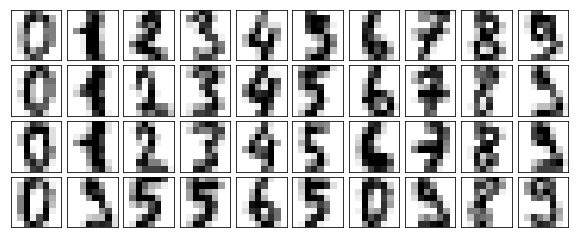

In [8]:
def plot_digits(data):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(8, 8), #reshaping the 64 features into the 8X8 pixels format
                  cmap='binary', interpolation='nearest',
                  clim=(0, 16))
plot_digits(mnist['data'])

#Source:https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

There are 64 dimensions, therefore, visualizing the data is difficult. Howver, we could use PCA to reduce the data into 2 dimensions and try to plot them according to those

In [9]:
from sklearn.decomposition import PCA

In [10]:
pca = PCA(2)  # project from 64 to 2 dimensions
mnist_reduced = pca.fit_transform(mnist['data'])

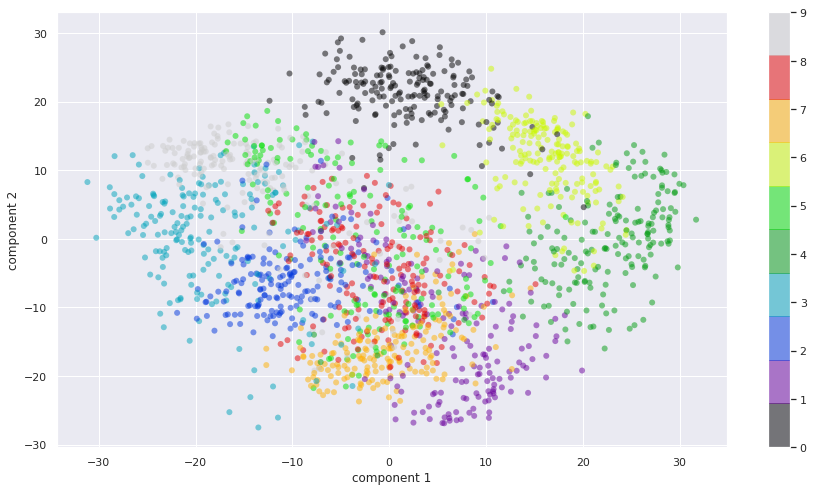

In [11]:
sns.set()
fig, ax = plt.subplots(figsize=(15,8))
plt.scatter(mnist_reduced[:, 0], mnist_reduced[:, 1],
            c=mnist['target'], edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

#Source:https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

We can se the 10 classes overlapping among each other. If we where to use just the reduced dimensions in our training, a linear kernel would not the best to find the right hyperplane. However, we will proceed to train our model on all the features and see the results. Should it prove to be to dispendious to train, we might consider applying dimensionality reduction.

## SVM

In [7]:
X=mnist['data']
y=mnist['target']

We should check whether our target variable is balanced

In [13]:
import collections

In [14]:
collections.Counter(y)

Counter({0: 178,
         1: 182,
         2: 177,
         3: 183,
         4: 181,
         5: 182,
         6: 181,
         7: 179,
         8: 174,
         9: 180})

It looks like it is. The model won't be biased by unbalanceness.

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

In [10]:
from sklearn.svm import SVC

In [11]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

We will use k-fold cross-validation to train SVM models with different Cs and kernels and compare them. 

First, we create a list with the possible model combinations.

In [19]:
c_params= [0.01, 0.1, 1, 10, 100]
kernels= ['rbf', 'poly', 'sigmoid', 'linear']

In [24]:
models = []
for c in c_params:
    for kernel in kernels:
        models.append(SVC(C=c, kernel=kernel, random_state=5))

In [12]:
from sklearn.model_selection import KFold

In [22]:
kf=KFold(10, random_state=11) 

We could have done the CV using grid search or cross-validation_score functions of sklearn. However, we would like to compare the models not only in terms of accuracy score, but also in terms of number of support vectors. To do the latter, we had no choice but to create our own CV loop.

In [23]:
cv_df = pd.DataFrame() #creating the dataframe to store the CV results into
entries = []

for model in models: #iterating through the model combinations
    l_acc_test=[]
    l_acc_train=[]
    l_n_sup=[]
    #We apply CV only on the train sample, not the test one. The latter will be used to measure the generalization
    #error of the best performing model.Therefore, it needs to be kept aside in this phase, so that the model
    #do not see it.
    for train, test in kf.split(X_train, y_train): #this is the loop for iterating across the kfold splits
        model.fit(X_train[train], y_train[train])#kf.split creates splits of the indexes. 
        n_sup=len(model.support_) # getting the number of the support vectors
        c=model.get_params(deep=False)['C'] 
        kernel=model.get_params(deep=False)['kernel']
        pred=model.predict(X_train[test])
        pred_tr=model.predict(X_train[train])
        acc_test = accuracy_score(y_train[test],pred) #computing the accuracy on the test
        acc_train = accuracy_score(y_train[train],pred_tr) #computing the accuracy on the train
        l_acc_test.append(acc_test)
        l_acc_train.append(acc_train)
        l_n_sup.append(n_sup)
    #Now we take the average of our metrics of interest and store them in the DataFrame
    entries.append((c, kernel, np.mean(l_acc_test),np.mean(l_acc_train),np.mean(l_n_sup)))
cv_df = pd.DataFrame(entries, columns=['C','kernel','mean_test_score', 'mean_train_score', 
                                       'mean_number_of_supports'])
        

In [24]:
cv_df

,C,kernel,mean_test_score,mean_train_score,mean_number_of_supports
0,0.01,rbf,0.065394,0.108095,1293.3
1,0.01,poly,0.990953,1.000000,432.2
2,0.01,sigmoid,0.065394,0.108095,1289.6
3,0.01,linear,0.980512,0.999149,392.0
4,0.10,rbf,0.065394,0.108095,1293.3
5,0.10,poly,0.990953,1.000000,432.2
6,0.10,sigmoid,0.065394,0.108095,1289.6
7,0.10,linear,0.979817,1.000000,391.4
8,1.00,rbf,0.419760,1.000000,1293.3
9,1.00,poly,0.990953,1.000000,432.2


We try to visualize how the accuracy varies acroos kernels and C parameters in the training and test samples.

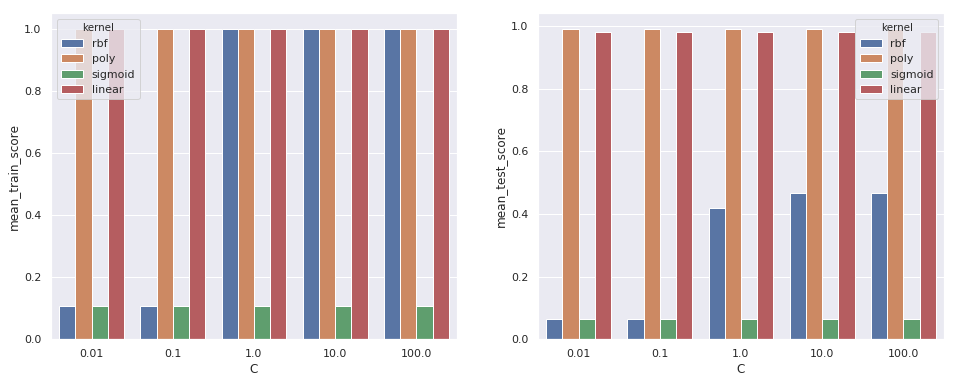

In [25]:
fig, ax = plt.subplots(ncols=2, figsize=(16,6))
sns.barplot(x='C', y='mean_train_score', hue= 'kernel', data=cv_df, ax=ax[0]);
sns.barplot(x='C', y='mean_test_score', hue= 'kernel', data=cv_df, ax=ax[1]);

From the left graph, we can see that rbf accuracy improves as C increases; however, this is creating overfitting. In fact, looking at the test results on the right graph, we see a significantly lower performance of the rbf model.
The sigmoid model performs poorly, independently of C, both in the train and in the test sample.
Both the linear and polynomial kernels show an outstanding accuracy, regardless of C. 

C represents the weight given to the loss function in the SVM model and represents the trade-off between correct classification of training examples against maximization of the decision function’s margin. The higher the C, the higher the cost of mis-classification. This makes the model reduce the margins between the support vectors and the hyperplane, reducing the space in which it is penalised. This however, leads to overfitting and makes the model more sensitive to outliers. A lower C, instead, will encourage a larger margin, therefore a simpler decision function, at the cost of training accuracy. In other words, C behaves as a regularization parameter in the SVM.

Below we can see the average number of support vectors across the different kernels and C parameters. We would expect that as C increases, the number of support vector decreases (the model tries to be more precise). However, the data show a constant behaviour across the C. The only difference in the number of support vectors seem to be determined by the kernel. Linear and polynomial have on average less than half the support vectors of the rbf and sigmoid kernels.

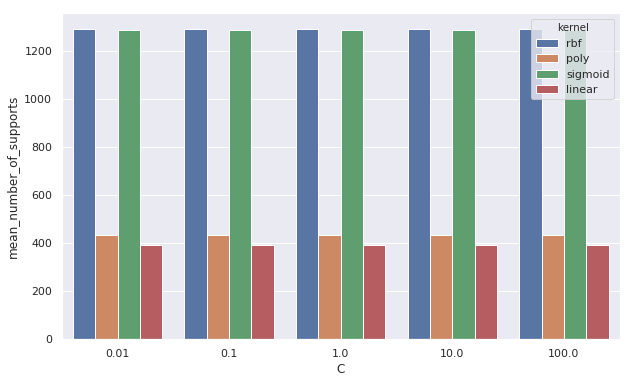

In [26]:
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(x='C', y='mean_number_of_supports', hue= 'kernel', data=cv_df);


Let's now find out the best performer in the test:

In [28]:
cv_df.loc[cv_df['mean_test_score']==cv_df['mean_test_score'].max()]

,C,kernel,mean_test_score,mean_train_score,mean_number_of_supports
1,0.01,poly,0.990953,1.0,432.2
5,0.10,poly,0.990953,1.0,432.2
9,1.00,poly,0.990953,1.0,432.2
13,10.00,poly,0.990953,1.0,432.2
17,100.00,poly,0.990953,1.0,432.2


Looks like the polynomial kernel wins. With any C specifications. We will run GridSearch CV to double check.

In [18]:
from sklearn.model_selection import GridSearchCV

In [26]:
pg = dict(C=c_params, kernel=kernels)

In [25]:
svc1 = SVC(random_state=5)

In [27]:
clf1=GridSearchCV(svc1, param_grid=pg, cv=10, scoring='accuracy')

In [28]:
clf1.fit(X_train, y_train)

/home/al1190/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=5,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [29]:
print(clf1.best_params_)
print(clf1.best_score_)

{'C': 0.01, 'kernel': 'poly'}
0.9909533750869868


The result is very very close to the one we have. We can proceed to train this model specification on the whole train sample and test it with the test one.

## Predictions

In [33]:
svc_best1= SVC(C=0.01, kernel='poly', random_state=5)

In [34]:
svc_best1.fit(X_train, y_train)

SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='poly', max_iter=-1, probability=False, random_state=5,
  shrinking=True, tol=0.001, verbose=False)

In [35]:
len(svc_best1.support_) #number of support vectors

458

In [36]:
predictions1 = svc_best1.predict(X_test)

Let's visualize the confusion matrix.

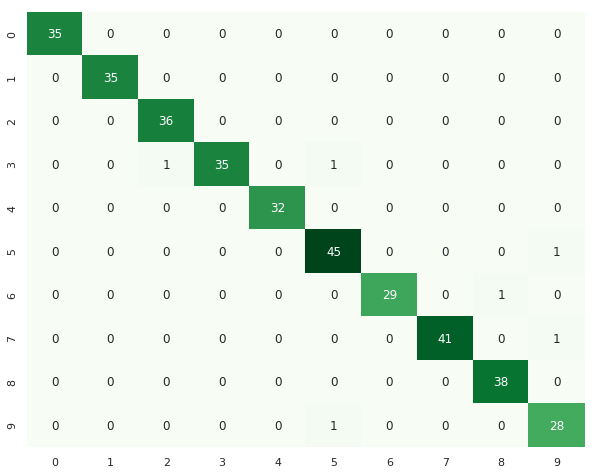

In [34]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test, predictions1), cmap='Greens', cbar=False, annot=True);

Looking at the confusion matrix, it seems there are very few mistakes. We will print the images of first 40 digits of the test sample and see how our predictions compare with the actual label.

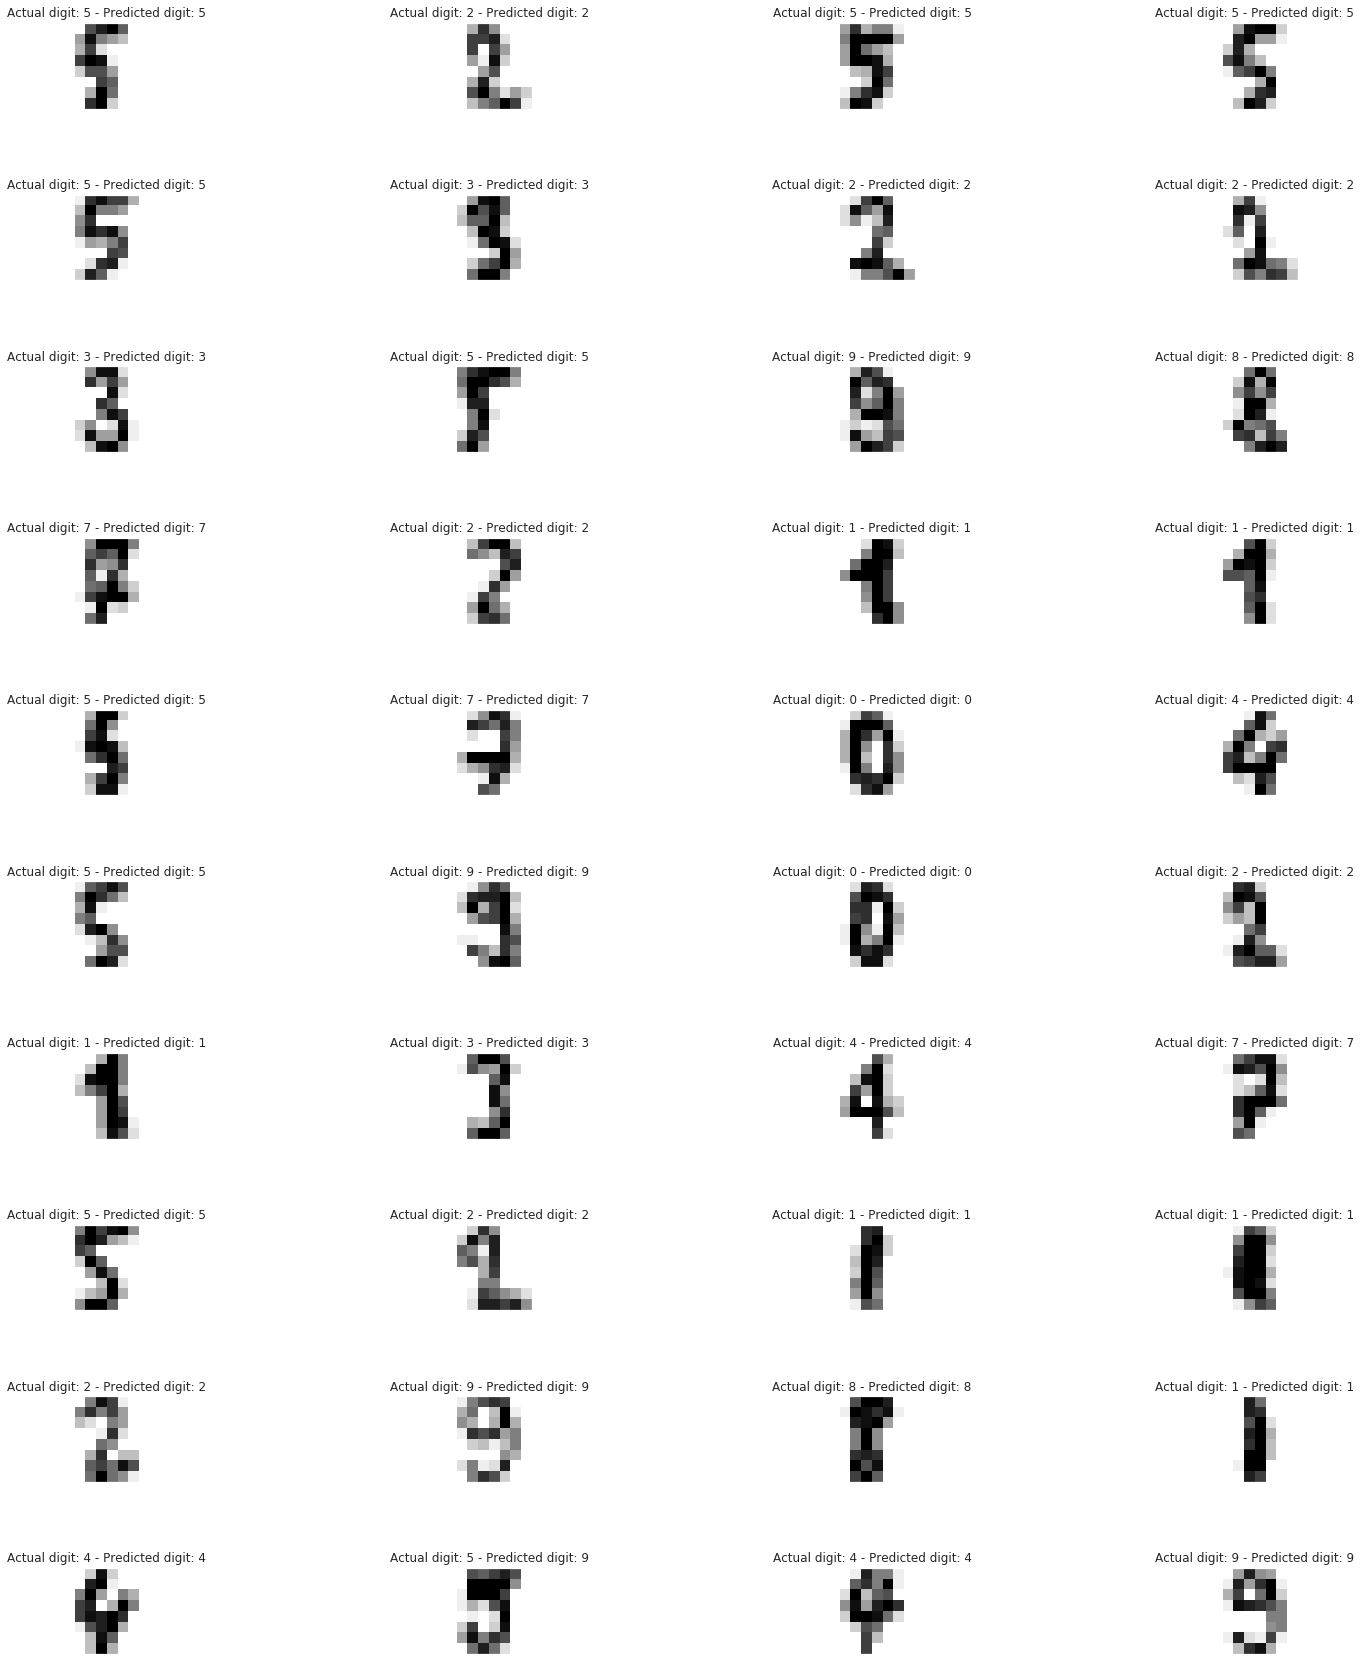

In [35]:
fig, axes = plt.subplots(10, 4, figsize=(24, 30),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=1, wspace=1))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_test[i].reshape(8, 8), #reshaping the 64 features into the 8X8 pixels format
              cmap='binary', interpolation='nearest',clim=(0, 16))
    ax.set_title('Actual digit: '+str(y_test[i])+' - Predicted digit: '+str(predictions1[i]))
    

The model predicts really well. Honestly, in some case it recognises the digits better than us. There is only one mistake: on the last row, second column, the actual digit is 5, while the model predicts 9. However, looking at the image, it is a borderline case.

Now we look at the scores of our model.

In [36]:
print(classification_report(y_test,predictions1))
print('Accuracy score: '+str(accuracy_score(y_test,predictions1).round(2)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        35
           2       0.97      1.00      0.99        36
           3       1.00      0.95      0.97        37
           4       1.00      1.00      1.00        32
           5       0.96      0.98      0.97        46
           6       1.00      0.97      0.98        30
           7       1.00      0.98      0.99        42
           8       0.97      1.00      0.99        38
           9       0.93      0.97      0.95        29

   micro avg       0.98      0.98      0.98       360
   macro avg       0.98      0.98      0.98       360
weighted avg       0.98      0.98      0.98       360

Accuracy score: 0.98


As we could see from the image grid, the model has very high scores. It is interested to notice, that number 9 is the label with the lowest scores, followed by number 5. Indeed, in the image grid, those two digits where the objects of the only mistake.

## More hyper-parameters tuning

Let's see what happens if we change more hyper parameters

In [69]:
c_params= [0.01, 0.1, 1, 10, 100]
kernels= ['rbf', 'poly', 'sigmoid', 'linear']
degrees = [3,5,7]
gammas= [0.1, 1, 10]
dfs= ['ovr', 'ovo']

In [70]:
models = []
for c in c_params:
    for kernel in kernels:
        for degree in degrees:
            for gamma in gammas:
                for function in dfs:
                    models.append(SVC(C=c, kernel=kernel, gamma=gamma, 
                                      degree=degree, decision_function_shape=function, random_state=5))

In [71]:
#Warning: takes quite a lot to run...
cv_df2 = pd.DataFrame() #creating the dataframe to store the CV results into
entries = []

for model in models: #iterating through the model combinations
    l_acc_test=[]
    l_acc_train=[]
    l_n_sup=[]
    #We apply CV only on the train sample, not the test one. The latter will be used to measure the generalization
    #error of the best performing model.Therefore, it needs to be kept aside in this phase, so that the model
    #do not see it.
    for train, test in kf.split(X_train, y_train): #this is the loop for iterating across the kfold splits
        model.fit(X_train[train], y_train[train])#kf.split creates splits of the indexes. 
        n_sup=len(model.support_) # getting the number of the support vectors
        c=model.get_params(deep=False)['C'] 
        kernel=model.get_params(deep=False)['kernel']
        degree=model.get_params(deep=False)['degree']
        gamma=model.get_params(deep=False)['gamma']
        dec_func=model.get_params(deep=False)['decision_function_shape']
        pred=model.predict(X_train[test])
        pred_tr=model.predict(X_train[train])
        acc_test = accuracy_score(y_train[test],pred) #computing the accuracy on the test
        acc_train = accuracy_score(y_train[train],pred_tr) #computing the accuracy on the train
        l_acc_test.append(acc_test)
        l_acc_train.append(acc_train)
        l_n_sup.append(n_sup)
    #Now we take the average of our metrics of interest and store them in the DataFrame
    entries.append((c, kernel, degree, gamma, dec_func, np.mean(l_acc_test),np.mean(l_acc_train),np.mean(l_n_sup)))
cv_df2 = pd.DataFrame(entries, columns=['C','kernel','degree','gamma','decision_function',
                                        'mean_test_score', 'mean_train_score', 
                                       'mean_number_of_supports'])
        

In [72]:
cv_df2.head()

,C,kernel,degree,gamma,decision_function,mean_test_score,mean_train_score,mean_number_of_supports
0,0.01,rbf,3,0.1,ovr,0.065394,0.108095,1293.3
1,0.01,rbf,3,0.1,ovo,0.065394,0.108095,1293.3
2,0.01,rbf,3,1.0,ovr,0.065394,0.108095,1293.3
3,0.01,rbf,3,1.0,ovo,0.065394,0.108095,1293.3
4,0.01,rbf,3,10.0,ovr,0.065394,0.108095,1293.3


In [73]:
cv_df2.shape

(360, 8)

We try to visualize how the accuracy varies acroos kernels and C parameters in the training and test samples.

In [74]:
#We need to groupby our dataframe to see the barplots, because we have more parameters combinations now.
train_score_kernel=cv_df2.groupby(['kernel', 'C'], as_index=False)['mean_train_score'].mean()
test_score_kernel= cv_df2.groupby(['kernel', 'C'], as_index=False)['mean_test_score'].mean()

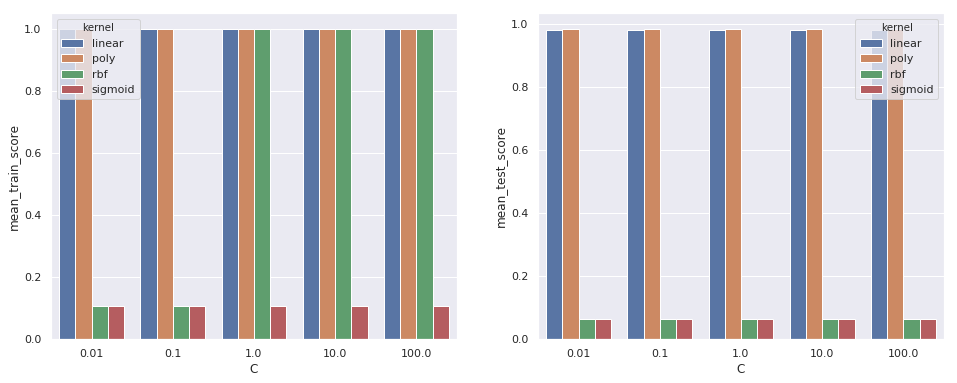

In [75]:
fig, ax = plt.subplots(ncols=2, figsize=(16,6))
sns.barplot(x='C', y='mean_train_score', hue= 'kernel', data=train_score_kernel, ax=ax[0]);
sns.barplot(x='C', y='mean_test_score', hue= 'kernel', data=test_score_kernel, ax=ax[1]);

Again, as in the previous case, linear and polynomial kernels show the best performance. The rbf kernel instead, shows signs of overfitting as C increases.

In [76]:
number_support_kernel=cv_df2.groupby(['kernel', 'C'], as_index=False)['mean_number_of_supports'].mean()

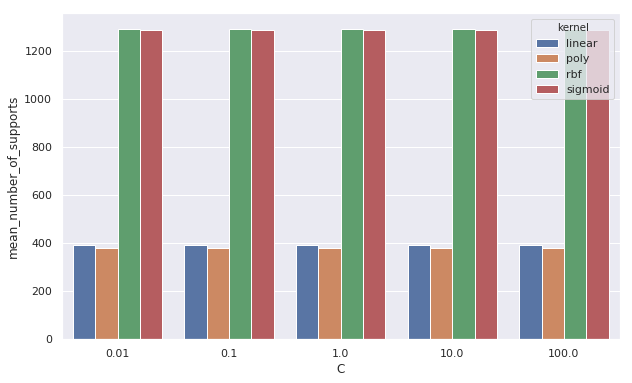

In [77]:
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(x='C', y='mean_number_of_supports', hue= 'kernel', data=number_support_kernel);


We can see that as C increases from 0.01 to 1 the number of support vectors in the rbf kernel decreases. As before, the main difference in the average number of support vectors is driven by the kernel used, rather than the value of C.

We will look now at the effect of gamma across the different models. The gamma parameter defines how far the influence of a single training example reaches, with low values meaning ‘far’ and high values meaning ‘close’. Gamma can be seen as the inverse of the radius of influence of samples selected by the model as support vectors. If gamma is too large, the radius of the area of influence of the support vectors only includes the support vector itself and no amount of regularization with C will be able to prevent overfitting.
When gamma is very small, the model is too constrained and cannot capture the complexity or “shape” of the data. The region of influence of any selected support vector would include the whole training set. 

In [78]:
train_score_gamma=cv_df2.groupby(['kernel', 'gamma'], as_index=False)['mean_train_score'].mean()
test_score_gamma= cv_df2.groupby(['kernel', 'gamma'], as_index=False)['mean_test_score'].mean()

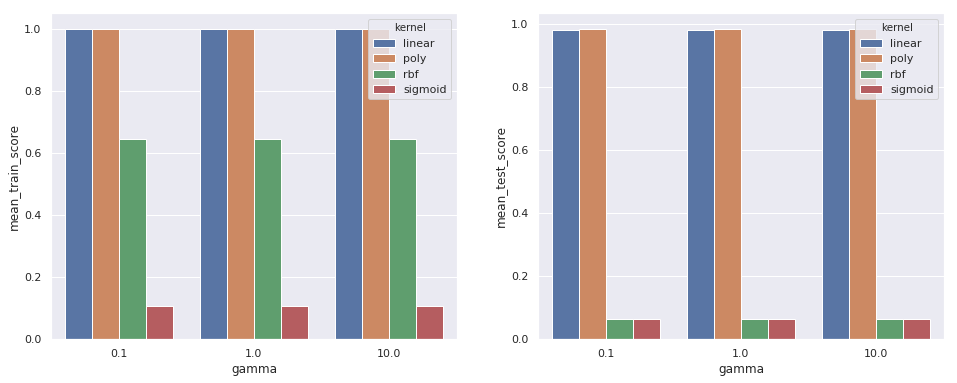

In [80]:
fig, ax = plt.subplots(ncols=2, figsize=(16,6))
sns.barplot(x='gamma', y='mean_train_score', hue= 'kernel', data=train_score_gamma, ax=ax[0]);
sns.barplot(x='gamma', y='mean_test_score', hue= 'kernel', data=test_score_gamma, ax=ax[1]);

We can see that, as for the parameter C, the gamma does not really affect the accuracy of the models, which is instead driven by the kernel. Also, rbf seems to be overfitting.

In [81]:
cv_df2.loc[cv_df2['mean_test_score']==cv_df2['mean_test_score'].max()]

,C,kernel,degree,gamma,decision_function,mean_test_score,mean_train_score,mean_number_of_supports
18,0.01,poly,3,0.1,ovr,0.990953,1.0,432.2
19,0.01,poly,3,0.1,ovo,0.990953,1.0,432.2
20,0.01,poly,3,1.0,ovr,0.990953,1.0,432.2
21,0.01,poly,3,1.0,ovo,0.990953,1.0,432.2
22,0.01,poly,3,10.0,ovr,0.990953,1.0,432.2
23,0.01,poly,3,10.0,ovo,0.990953,1.0,432.2
90,0.10,poly,3,0.1,ovr,0.990953,1.0,432.2
91,0.10,poly,3,0.1,ovo,0.990953,1.0,432.2
92,0.10,poly,3,1.0,ovr,0.990953,1.0,432.2
93,0.10,poly,3,1.0,ovo,0.990953,1.0,432.2


It looks like the polynomial kernel wins again. Let's use again GridSearch to double check.

In [82]:
pg2 = dict(C=c_params, kernel=kernels, gamma=gammas, degree=degrees, decision_function_shape=dfs)

In [83]:
svc2 = SVC(random_state=5)

In [84]:
clf2=GridSearchCV(svc2, param_grid=pg2, cv=10, scoring='accuracy')

In [85]:
clf2.fit(X_train, y_train)

/home/al1190/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear'], 'gamma': [0.1, 1, 10], 'degree': [3, 5, 7], 'decision_function_shape': ['ovr', 'ovo']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [86]:
print(clf2.best_params_)
print(clf2.best_score_)

{'C': 0.01, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.1, 'kernel': 'poly'}
0.9909533750869868


GridSearch confirmed our results. Moreover, this is the same model as the one before, execpt for the gamma.

In [26]:
svc_best2= SVC(C=0.01, kernel='poly', decision_function_shape='ovr', degree=3, gamma=0.1, random_state=5)

In [27]:
svc_best2.fit(X_train, y_train)

SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='poly',
  max_iter=-1, probability=False, random_state=5, shrinking=True,
  tol=0.001, verbose=False)

In [28]:
len(svc_best2.support_) #number of support vectors

458

In [29]:
predictions2 = svc_best2.predict(X_test)

In [31]:
print(classification_report(y_test, predictions2))
print("Accuracy score: ", accuracy_score(y_test, predictions2).round(2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        35
           2       0.97      1.00      0.99        36
           3       1.00      0.95      0.97        37
           4       1.00      1.00      1.00        32
           5       0.96      0.98      0.97        46
           6       1.00      0.97      0.98        30
           7       1.00      0.98      0.99        42
           8       0.97      1.00      0.99        38
           9       0.93      0.97      0.95        29

   micro avg       0.98      0.98      0.98       360
   macro avg       0.98      0.98      0.98       360
weighted avg       0.98      0.98      0.98       360

Accuracy score:  0.98


## Random Forest

We will train a Random Forest classifier to see how if we can also get such a high accuracy as we did with SVM.

In [13]:
from sklearn.ensemble import RandomForestClassifier

In [14]:
n_trees = [50,100,150]
criterion= ['gini', 'entropy']
md= [10,50,100]
mss = [10,50,100]
msl= [10,50,100]

In [15]:
pg3 = dict(n_estimators=n_trees, criterion=criterion, max_depth=md, min_samples_split=mss, min_samples_leaf=msl)

In [16]:
forest = RandomForestClassifier(random_state=13)

In [19]:
clf3=GridSearchCV(forest, param_grid=pg3, cv=10, scoring='accuracy')

In [20]:
clf3.fit(X_train, y_train)

/home/al1190/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=13, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [50, 100, 150], 'criterion': ['gini', 'entropy'], 'max_depth': [10, 50, 100], 'min_samples_split': [10, 50, 100], 'min_samples_leaf': [10, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [21]:
print(clf3.best_params_)
print(clf3.best_score_)

{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 150}
0.9610299234516354


In [22]:
forest_best = RandomForestClassifier(criterion= 'entropy', max_depth=10, min_samples_leaf=10, 
                                     min_samples_split=10, n_estimators=150,random_state=13)

In [23]:
forest_best.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=None,
            oob_score=False, random_state=13, verbose=0, warm_start=False)

In [24]:
prediction_forest = forest_best.predict(X_test)

In [32]:
print(classification_report(y_test, prediction_forest))
print("Accuracy score: ", accuracy_score(y_test, prediction_forest).round(2))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        35
           1       0.97      0.97      0.97        35
           2       0.95      1.00      0.97        36
           3       1.00      0.84      0.91        37
           4       0.97      0.97      0.97        32
           5       0.91      0.91      0.91        46
           6       1.00      0.97      0.98        30
           7       0.95      0.98      0.96        42
           8       0.88      0.92      0.90        38
           9       0.81      0.90      0.85        29

   micro avg       0.94      0.94      0.94       360
   macro avg       0.94      0.94      0.94       360
weighted avg       0.94      0.94      0.94       360

Accuracy score:  0.94


It looks like SVM performs better at classifying the digits.

In [37]:
print("Accuracy score SVM1: ", accuracy_score(y_test, predictions1).round(2))
print("Accuracy score SVM2: ", accuracy_score(y_test, predictions2).round(2))
print("Accuracy score Random Forest: ", accuracy_score(y_test, prediction_forest).round(2))

Accuracy score SVM1:  0.98
Accuracy score SVM2:  0.98
Accuracy score Random Forest:  0.94
